In [1]:
# Import module
import csv
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from scipy.stats import boxcox
from google.colab import files

In [2]:
# Upload Original Files
uploaded = files.upload()

Saving 20230317.xlsx to 20230317.xlsx


In [3]:
path_Ori = './20230317.xlsx'
path_file = './20230317.csv'

# delete big title and save to csv
def xlsx_to_csv_pd():
    data_xls = pd.read_excel(path_Ori, index_col=0, header=0)
    data_xls.to_csv(path_file, encoding='utf-8', header=None)

xlsx_to_csv_pd() # 2 csv

In [4]:
# Complete the title
with open(path_file) as f:
    data=[row for row in csv.reader(f)]

with open(path_file, 'w', encoding='utf-8') as f:
    w = csv.writer(f)
    data[0][0]="Model"
    for row in data:
        w.writerow(row)  

In [5]:
data = pd.read_csv(path_file)
data.columns = data.columns.str.replace(' ', '') # delete space
data.to_csv(path_file, encoding='utf-8', index=None)
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Model         191 non-null    object 
 1   LPore         191 non-null    int64  
 2   MPore         191 non-null    int64  
 3   SPore         191 non-null    int64  
 4   CWST          191 non-null    int64  
 5   PoreSize      191 non-null    float64
 6   Flowrate(FR)  191 non-null    float64
 7   WBC(DR)       191 non-null    float64
 8   Valid-FR      191 non-null    int64  
 9   Valid-DR      191 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 15.0+ KB
None
            LPore       MPore       SPore        CWST    PoreSize  \
count  191.000000  191.000000  191.000000  191.000000  191.000000   
mean     0.821990    2.502618    9.026178   96.586387    4.025131   
std      0.512721    1.694804    2.944101   20.537812    0.856731   
min      0.000000    0.000000    0.

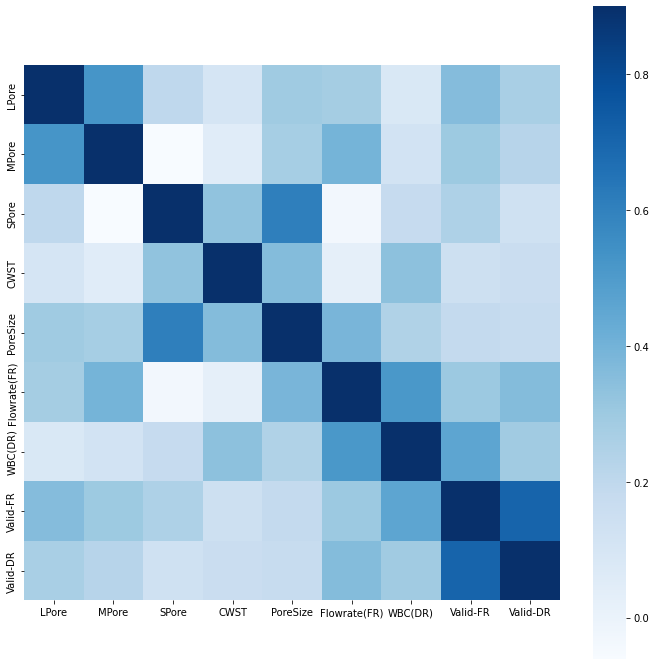

In [6]:
def draw_corr_picture(X):   # 相關係數圖
    corrmat = X.corr()
    plt.subplots(figsize=(12,12))
    sns.heatmap(corrmat,vmax=0.9,square=True,cmap='Blues')
    plt.show()

draw_corr_picture(data)

In [7]:
x = data[data.columns[1:11]]
y = data[["Flowrate(FR)"]] # FR

x = (x - x.min()) / (x.max() - x.min())

bestfeatures = SelectKBest(score_func=f_regression, k=8)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Flowrate(FR)']  #name the data_frame columns
print(featureScores.nlargest(11, 'Flowrate(FR)'))

          Specs  Flowrate(FR)
5  Flowrate(FR)  1.418634e+17
6       WBC(DR)  6.888145e+01
1         MPore  3.468861e+01
4      PoreSize  3.333434e+01
8      Valid-DR  2.869122e+01
7      Valid-FR  1.967640e+01
0         LPore  1.613394e+01
2         SPore  2.056758e-01
3          CWST  1.299457e-01


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


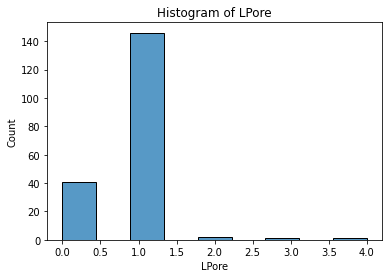

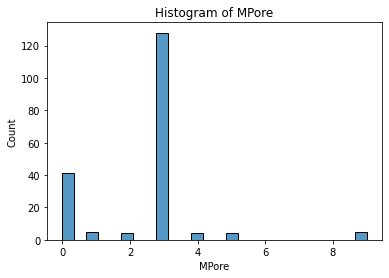

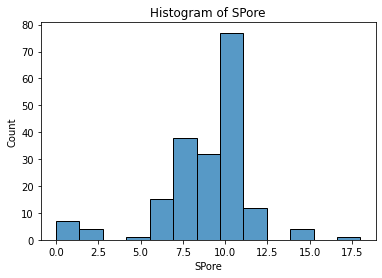

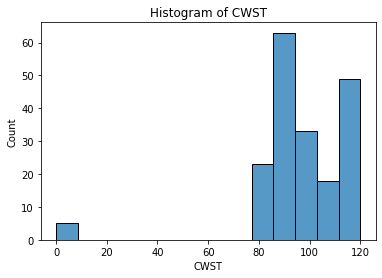

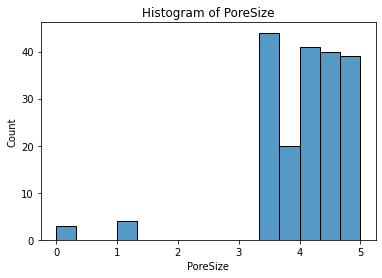

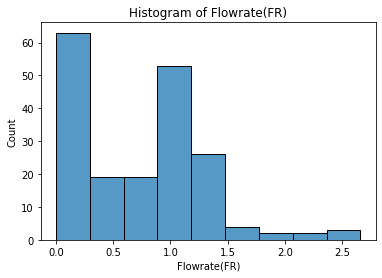

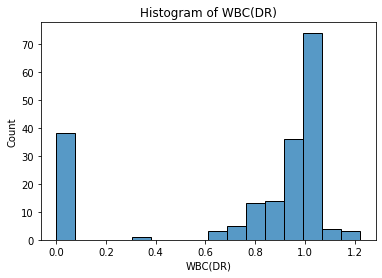

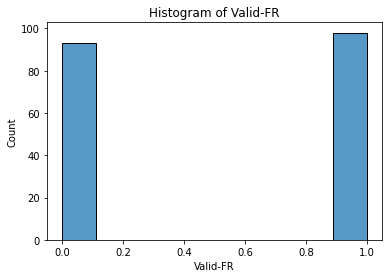

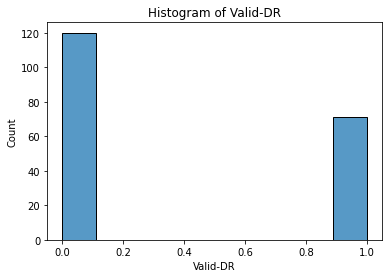

In [8]:
data = pd.read_csv(path_file)
features = data.drop(["Model"], axis=1)

for column in features.columns:
    plt.figure()
    sns.histplot(features[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.show()

In [9]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


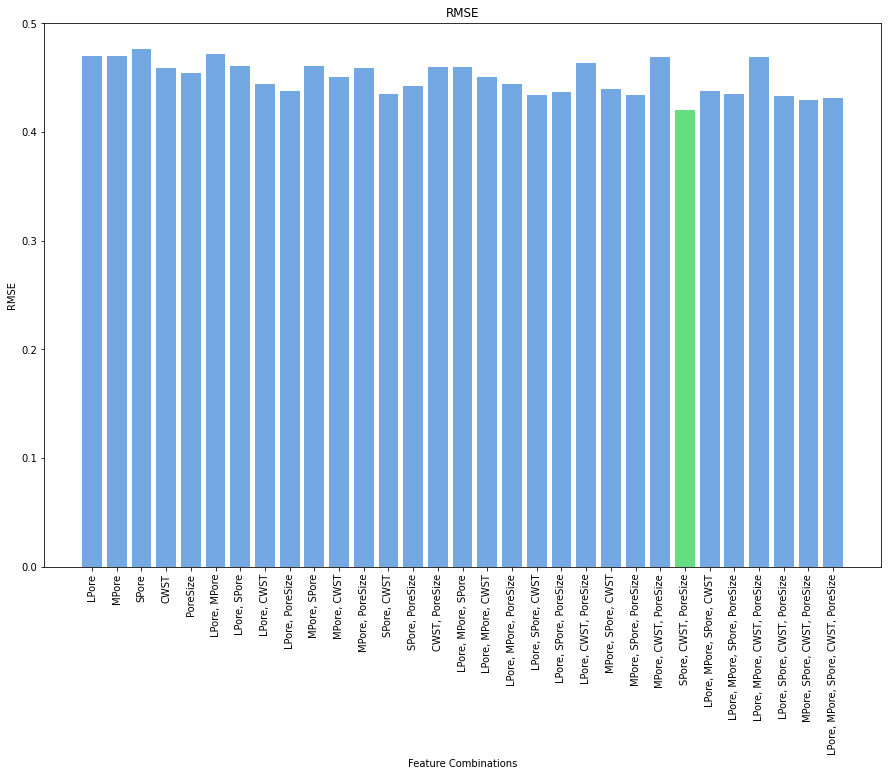

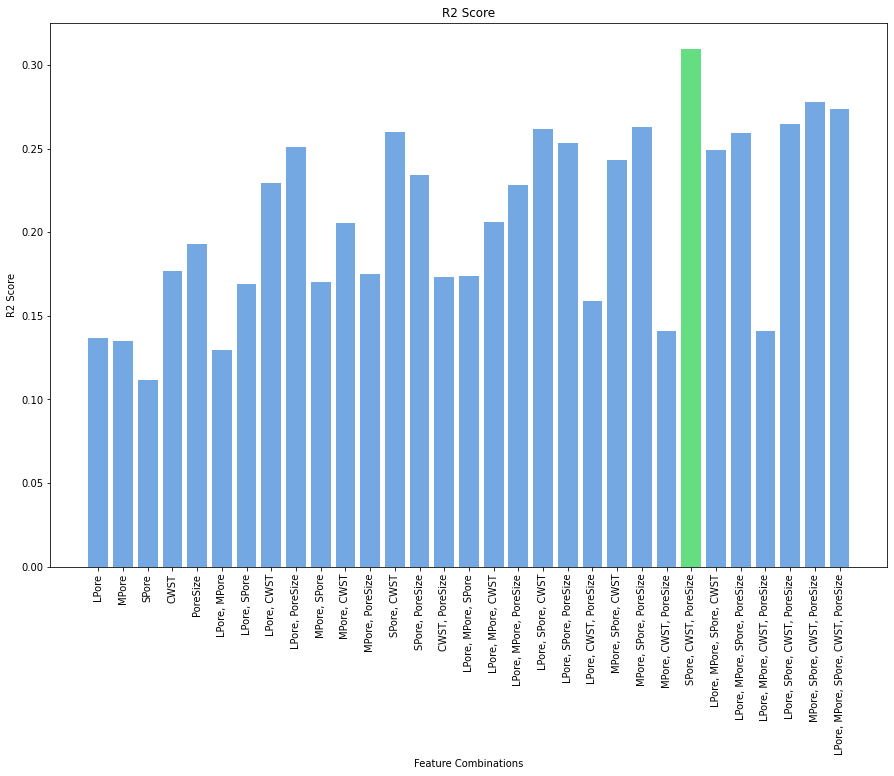

Best feature combination: ('SPore', 'CWST', 'PoreSize')
Best Root Mean squared error: 0.42010310180009075
Best R2 score: 0.30966635844959234


In [10]:
# !!!!!!! XGBoost !!!!!!!!

import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load CSV
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Pre-process
def preprocess_data(data):
    data = data.dropna()
    # Select features and target
    X = data.drop(["Model", "Flowrate(FR)","Valid-FR", "Valid-DR", "WBC(DR)"], axis=1)
    y = data["Flowrate(FR)"]
    return X, y

# Train
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(objective="reg:squarederror", n_estimators=1000, early_stopping_rounds=500)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    return model, X_test, y_test

# Evaluate
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def visualize_results(combination_labels, rmse_values, r2_values):
    # Identify the best RMSE and R2
    best_rmse_index = rmse_values.index(min(rmse_values))
    best_r2_index = r2_values.index(max(r2_values))

    # Set colors for the bars
    rmse_colors = ['#74a8e3'] * len(rmse_values)
    rmse_colors[best_rmse_index] = '#64de80'
    r2_colors = ['#74a8e3'] * len(r2_values)
    r2_colors[best_r2_index] = '#64de80'

    # Plot RMSE values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, rmse_values, color=rmse_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.title('RMSE')
    plt.show()

    # Plot R2 values
    plt.figure(figsize=(15, 10))
    plt.bar(combination_labels, r2_values, color=r2_colors)
    plt.xlabel('Feature Combinations')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=90)
    plt.title('R2 Score')
    plt.show()

def brute_force_search(data):
    X, y = preprocess_data(data)
    feature_combinations = []
    for i in range(1, len(X.columns) + 1):
        feature_combinations.extend(list(itertools.combinations(X.columns, i)))
    
    best_rmse = float('inf')
    best_r2 = 0
    best_combination = None
    best_model = None
    best_X_test = None
    best_y_test = None

    rmse_values = []
    r2_values = []
    combination_labels = []

    for combination in feature_combinations:
        X_comb = X[list(combination)]
        model, X_test, y_test = train_model(X_comb, y)
        rmse, r2 = evaluate_model(model, X_test, y_test)
        rmse_values.append(rmse)
        r2_values.append(r2)
        combination_labels.append(', '.join(combination))

        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_model = model
            best_X_test = X_test
            best_y_test = y_test
    
    visualize_results(combination_labels, rmse_values, r2_values)

    return best_combination, best_model, best_X_test, best_y_test

def main():
    file_path = path_file
    data = load_data(file_path)
    best_combination, best_model, best_X_test, best_y_test = brute_force_search(data)
    best_rmse, best_r2 = evaluate_model(best_model, best_X_test, best_y_test)
    
    print(f"Best feature combination: {best_combination}")
    print(f"Best Root Mean squared error: {best_rmse}")
    print(f"Best R2 score: {best_r2}")

if __name__ == "__main__":
    main()